In [6]:
import obspy as ob
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from obspy.clients.fdsn import Client
os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

In [52]:
def get_scnl(st):
    scnl_lst = []
    for tr in st:
        scnl_lst.append([tr.stats.network, tr.stats.station, tr.stats.channel[:2]])
    scnl_df = pd.DataFrame(scnl_lst, columns=['network','station','channel'])
    scnl_df.drop_duplicates(inplace=True)
    scnl_df.reset_index(drop=True, inplace=True)
    
    st_lst = []
    sr_lst = []
    for i, r in scnl_df.iterrows():
        st_tmp = st.select(network = r.network, station = r.station, channel=f'{r.channel}?')
        st_lst.append(st_tmp[0].stats.starttime)
        sr_lst.append(st_tmp[0].stats.sampling_rate)
    scnl_df['start_time'] = st_lst
    scnl_df['sampling_rate'] = 100.0
    return scnl_df

In [53]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None, title=True):
    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                       & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind, title)

    return ind, x[ind]

In [54]:
def normalize(data, axis=(1,)):
    """data shape: (nstn, twin, nch) """
    data -= np.mean(data, axis=axis, keepdims=True)
    std_data = np.std(data, axis=axis, keepdims=True)
    std_data[std_data == 0] = 1
    data /= std_data
    return data

In [69]:
def getArray(stream, stn, chn, ntw) :
    st2 = stream.select(station=stn, channel=f'{chn}?', network=ntw)
    st2=st2.detrend('constant')
    need_resampling=False
    for tr in st2:
        if tr.stats.sampling_rate!=100.0:
            need_resampling=True
    if need_resampling==True:
        st2.resample(100.0)
    st2=st2.merge(fill_value=0)
    #st2.taper(max_percentage=0.05, max_length=1.0)
    
    #st2.filter('bandpass',freqmin=2.0,freqmax=40.0) # band-pass filter with corners at 2 and 40 Hz
    st2.filter('bandpass',freqmin=1.0,freqmax=45.0) # band-pass filter with corners at 2 and 40 Hz

    st2 = st2.trim(min([tr.stats.starttime for tr in st2]),
                   max([tr.stats.endtime for tr in st2]),
                   pad=True, fill_value=0) # reference from PhaseNet

    npts = st2[0].stats.npts

    components = ['E', 'N', 'Z']
    data = np.zeros((npts, 3))
    for i, comp in enumerate(components) :
        tmp = st2.select(channel=f'{chn}{comp}')
        if len(tmp) == 1:
            data[:, i] = tmp[0].data
        elif len(tmp) == 0:
            print(f"Warning: Missing channel \"{comp}\" in {st2}")
        else:
            print(f"Error in {tmp}")
    return data, st2[0].stats.starttime

In [70]:
def getSegment(data, startT, stn, chn, ntw, twin=3000, tshift=500) : 
    tot_len = data.shape[0]
    tot_num = int(np.ceil(tot_len / twin))
    noverlap = int(twin / tshift)
    
    data2 = np.zeros((noverlap, tot_num, twin, 3))
    meta = []
    for i in range(noverlap) :
        for j in range(tot_num) :
            try :
                data2[i, j, :, :] = data[(j*twin+i*tshift):((j+1)*twin+i*tshift), :]
            except : # last part of data
                if j*twin+i*tshift < tot_len :
                    last_len = tot_len - (j*twin + i*tshift)
                    data2[i, j, :last_len, :] = data[(j*twin+i*tshift):((j+1)*twin+i*tshift), :]
            if i == 0 :
                meta.append([stn, chn, ntw, startT+(j*twin+i*tshift)/100, twin])
            
    return data2, meta

In [102]:
def picking(net, stn, chn, st, twin, stride):
    data, startT = getArray(st.copy(), stn, chn, net)
    data2, meta = getSegment(data, startT, stn, chn, net, twin=twin, tshift=stride)
    
    Y_result = np.zeros_like(data2)
    for i in range(data2.shape[0]):
        X_test = normalize(data2[i])
        Y_pred = model.predict(X_test)
        Y_result[i] = Y_pred
    
    y1, y2, y3, y4 = Y_result.shape
    Y_result2 = np.zeros((y1, y2*y3, y4))
    Y_result2[:, :, 2] = 1
    for i in range(y1) :
        Y_tmp = np.copy(Y_result[i]).reshape(y2*y3, y4)
        Y_result2[i, i*stride:, :] = Y_tmp[:(Y_tmp.shape[0]-i*stride), :]
        
    Y_med  = np.median(Y_result2, axis=0).reshape(y2, y3, y4)
    y1, y2, y3 = Y_med.shape
    Y_med = Y_med.reshape(y1* y2, y3)
    
    return data, Y_med   

In [141]:
def plot_results(net, stn, chn, data_total, Y_total):    
    fig = plt.figure(figsize=(7,5))
    ax1 = fig.add_subplot(4,1,1)
    ax2 = fig.add_subplot(4,1,2)
    ax3 = fig.add_subplot(4,1,3)
    ax4 = fig.add_subplot(4,1,4)
    ax1.plot(data_total[:,2], 'k', label='E')
    ax2.plot(data_total[:,1], 'k', label='N')
    ax3.plot(data_total[:,0], 'k', label='Z')
    
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax3.set_xticks([])
    
    ax4.plot(Y_total[:,0], color='b', label='P', zorder=10)
    ax4.plot(Y_total[:,1], color='r', label='S', zorder=10)
    ax4.plot(Y_total[:,2], color='gray', label='Noise')
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper right')
    ax4.legend(loc='upper right', ncol=3)
    
    plt.suptitle(f'{net}.{stn}..{chn}')
    plt.show() 

In [73]:
def get_picks(Y_total, net, stn, chn, sttime, sr):
    arr_lst = []
    P_idx, P_prob = detect_peaks(Y_total[:,0], mph=.3, mpd=50, show=False)
    S_idx, S_prob = detect_peaks(Y_total[:,1], mph=.3, mpd=50, show=False)    
    for idx_, p_idx in enumerate(P_idx):
        p_arr = sttime + (p_idx/sr)
        arr_lst.append([net, stn, chn, p_arr, P_prob[idx_], 'P'])
    for idx_, s_idx in enumerate(S_idx):
        s_arr = sttime + (s_idx/sr)
        arr_lst.append([net, stn, chn, s_arr, S_prob[idx_], 'S'])    
    return arr_lst

In [74]:
model_path = '/nas/DATA_JNU/model/bestmodel_RRU_20230217_1339.h5'
model = tf.keras.models.load_model(model_path)

In [61]:
client = Client("IRIS")

In [129]:
#Gyeongju
latitude = 35.76 
longitude = 129.19
origintime = ob.UTCDateTime("2016-09-12T11:32:54")

##Pohang
#latitude = 36.11 
#longitude = 129.37
#origintime = ob.UTCDateTime("2017-11-15T05:29:31")

#Buan
latitude = 35.70
longitude = 126.72
origintime = ob.UTCDateTime("2024-06-11T23:26:49")

tw=30

inventory = client.get_stations(latitude=latitude,
                                network='K?',
                                 longitude=longitude,
                                 maxradius=3.0,
                                 starttime=origintime,
                                 endtime=origintime+tw)

In [130]:
inventory

Inventory created at 2025-07-11T05:44:07.032200Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2024-06-11...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (2):
			KG, KS
		Stations (6):
			KG.TJN (TJN)
			KS.BUS3 (Geumjeong, South Korea)
			KS.CHJ3 (Chungju, South Korea)
			KS.NAWB (Namwon, South Korea)
			KS.SEO3 (Seoul, South Korea)
			KS.SH2B (Seawha, South Korea)
		Channels (0):


In [131]:
st = ob.Stream()

for network in inventory:
    for station in network:
        net = network.code
        sta = station.code
        try:
            st_tmp = client.get_waveforms(network=net,station=sta,location='*',channel='*',starttime=origintime-30,endtime=origintime+60)
        except:
            continue
        st += st_tmp

In [137]:
st = ob.read('/home/kgunwoo1/seismic/buan_100sps_100km/*')

In [75]:
st = ob.read()

In [138]:
scnl_df = get_scnl(st)
scnl_df

,network,station,channel,start_time,sampling_rate
0,KS,AMD,HG,2024-06-11T23:26:43.998397Z,100.0
1,KS,AMD,HH,2024-06-11T23:26:43.998399Z,100.0
2,KS,ANMA,HG,2024-06-11T23:26:44.003099Z,100.0
3,KS,BLGA,HG,2024-06-11T23:26:44.003097Z,100.0
4,KS,BUYB,HG,2024-06-11T23:26:43.998398Z,100.0
...,...,...,...,...,...
69,KS,WAJB,HG,2024-06-11T23:26:43.999990Z,100.0
70,KS,WAJB,HH,2024-06-11T23:26:43.999995Z,100.0
71,KS,WICA,HG,2024-06-11T23:26:44.003096Z,100.0
72,KS,YEGA,HG,2024-06-11T23:26:44.003101Z,100.0


In [146]:
Y_total =[]
data_total = []

for idx, row in scnl_df.iterrows():
    print(f'{row.network}.{row.station}..{row.channel}')
    data, Y_med = picking(row.network, row.station, row.channel, st.copy(), twin=3000, stride=500)
    data_total.append(data)
    Y_total.append(Y_med)
data_total = np.stack(data_total, axis=0)  
Y_total = np.stack(Y_total, axis=0)

KS.AMD..HG
KS.AMD..HH
KS.ANMA..HG
KS.BLGA..HG
KS.BUYB..HG
KS.BUYB..HH
KS.CGPA..HG
KS.CGYA..HG
KS.CHOA..HG
KS.CJDB..HG
KS.CJDB..HH
KS.DAYA..HG
KS.DGHA..HG
KS.DUSB..HG
KS.DUSB..HH
KS.ECDB..HG
KS.ECDB..HH
KS.GIJA..HG
KS.GKSA..HG
KS.GLSA..HG
KS.GOCB..HG
KS.GOCB..HH
KS.HAMB..HG
KS.HAMB..HH
KS.HMPA..HG
KS.IJDB..HG
KS.IJDB..HH
KS.IKSA..HG
KS.IKSB..HG
KS.IKSB..HH
KS.IMSB..HG
KS.IMSB..HH
KS.JAGA..HG
KS.JASA..HG
KS.JEDA..HG
KS.JEU2..HG
KS.JLSA..HG
KS.KMSB..HG
KS.KMSB..HH
KS.KWJ2..HG
KS.KWJ2..HH
KS.KWJU..HH
KS.MALA..HG
KS.MANA..HG
KS.MND..HG
KS.MND..HH
KS.MNDB..HG
KS.MNDB..HH
KS.MSMB..HG
KS.MSMB..HH
KS.NACA..HG
KS.NAHA..HG
KS.NAJA..HG
KS.NAWB..HG
KS.NAWB..HH
KS.NHPA..HG
KS.NOSA..HG
KS.OYDB..HG
KS.OYDB..HH
KS.PORA..HG
KS.PUAA..HG
KS.SCHA..HG
KS.SECA..HG
KS.SENA..HG
KS.SIJA..HG
KS.SMWA..HG
KS.SUCA..HG
KS.TAIA..HG
KS.TEJ2..HG
KS.WAJB..HG
KS.WAJB..HH
KS.WICA..HG
KS.YEGA..HG
KS.YUGA..HG


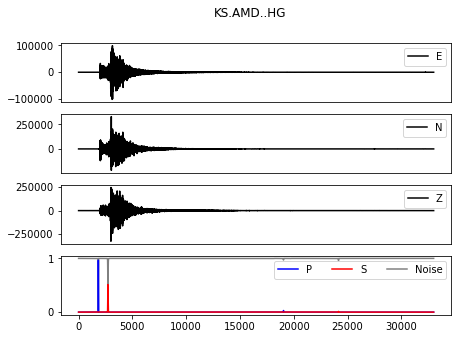

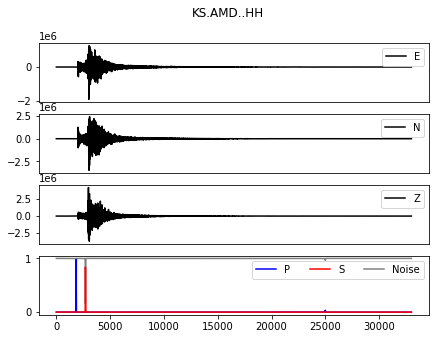

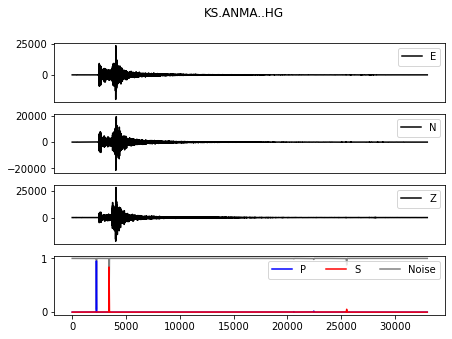

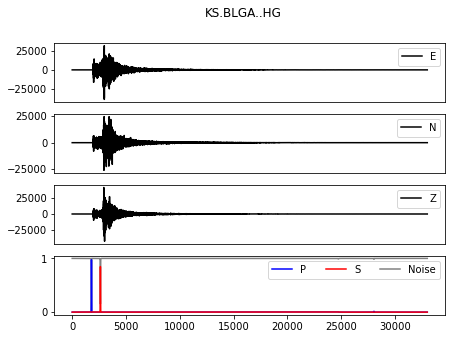

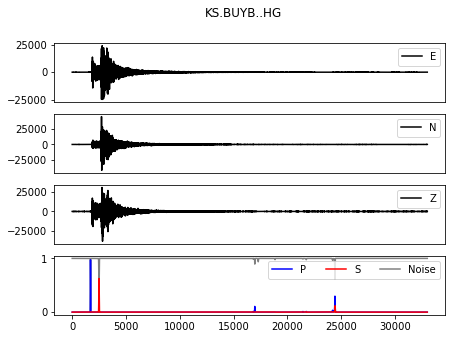

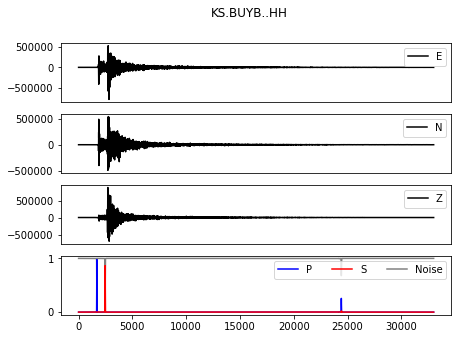

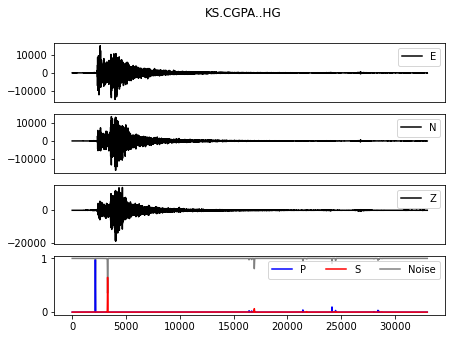

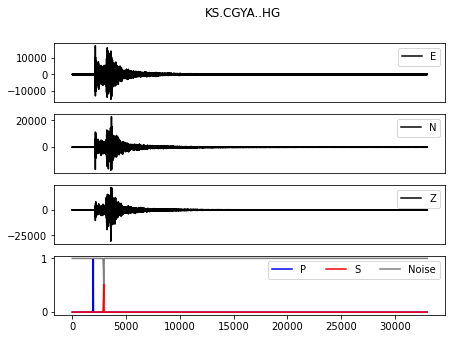

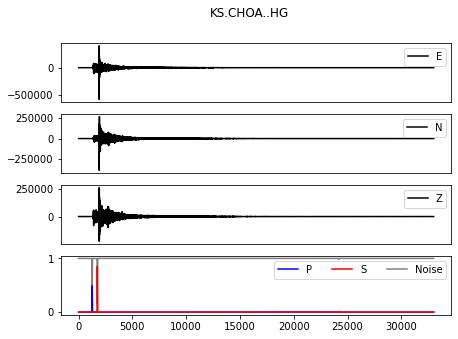

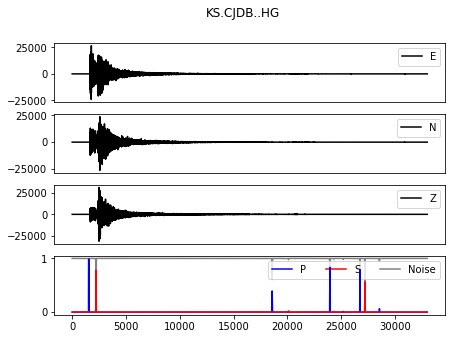

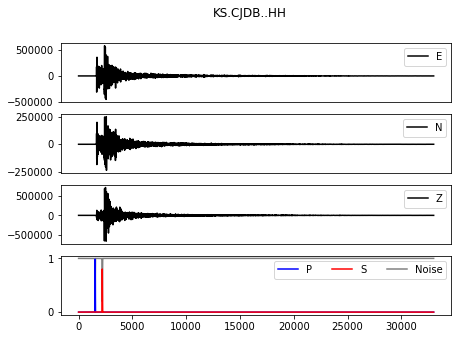

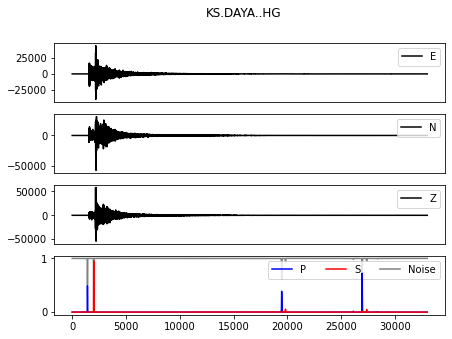

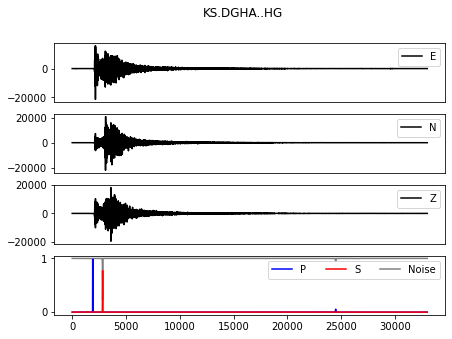

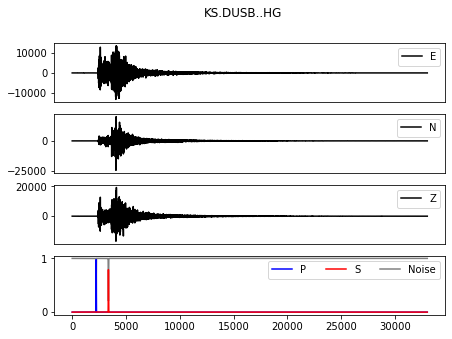

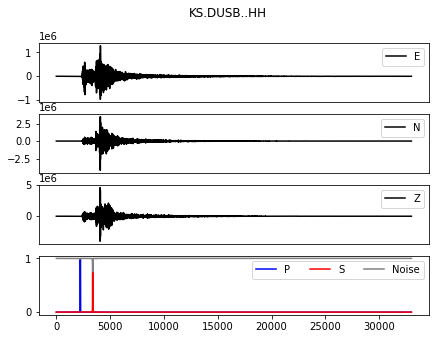

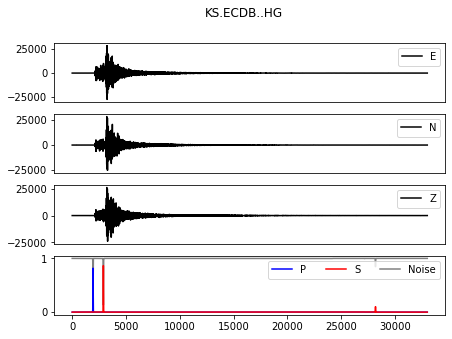

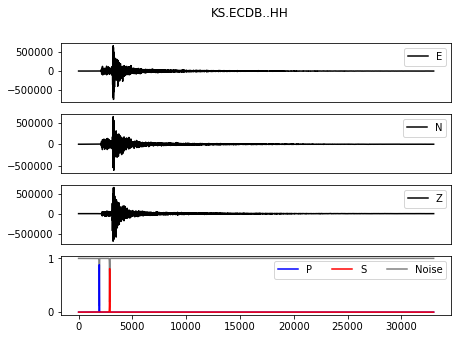

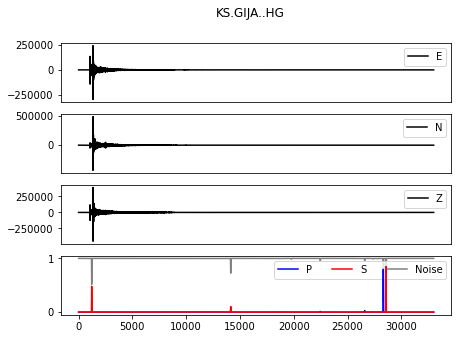

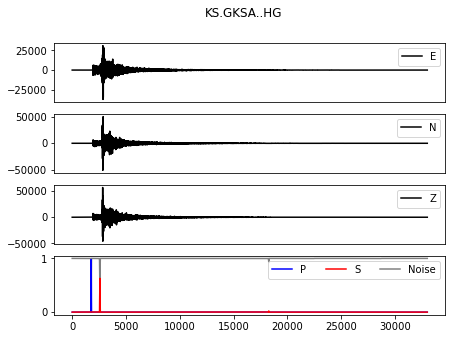

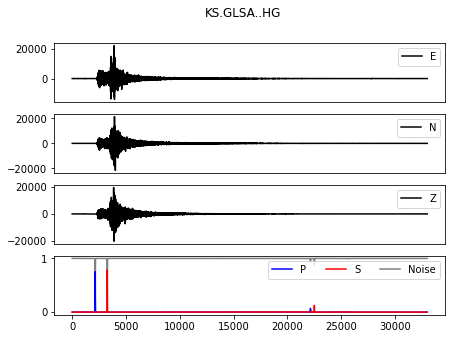

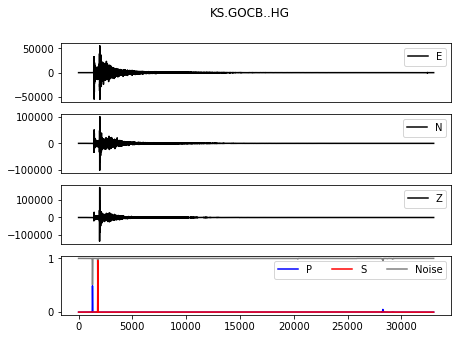

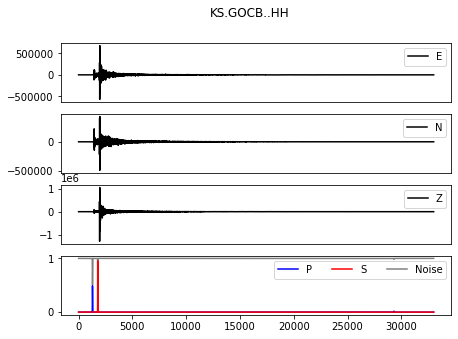

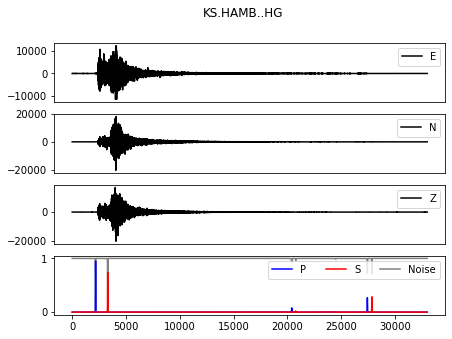

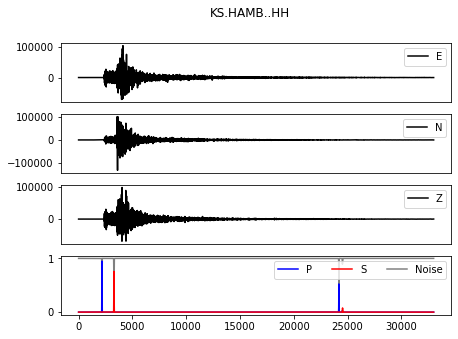

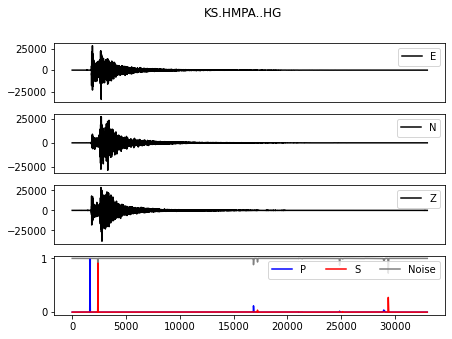

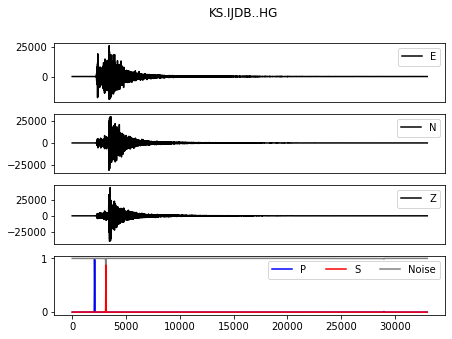

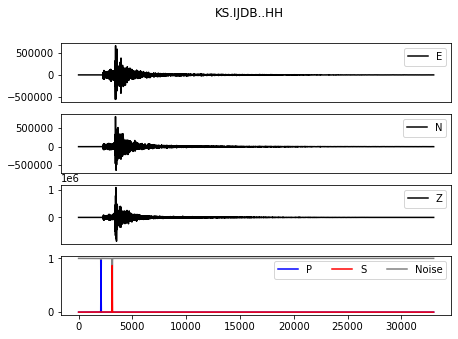

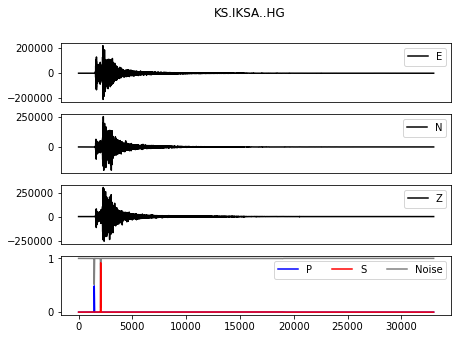

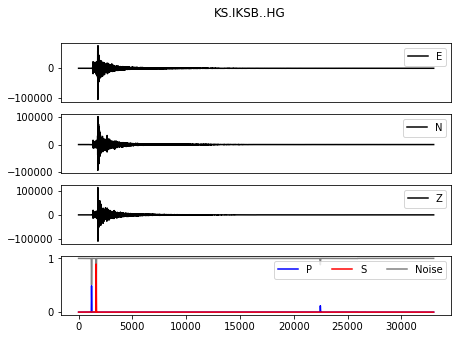

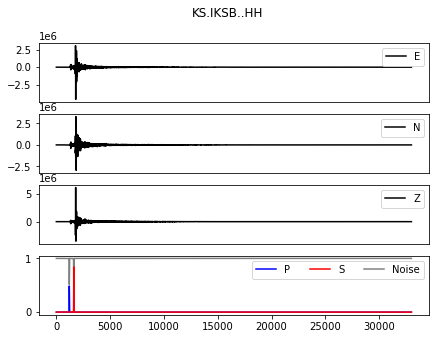

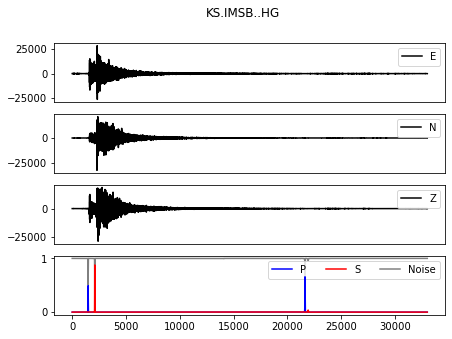

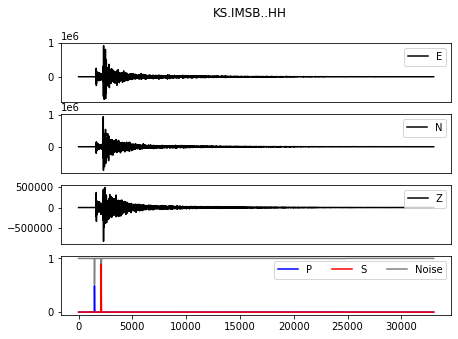

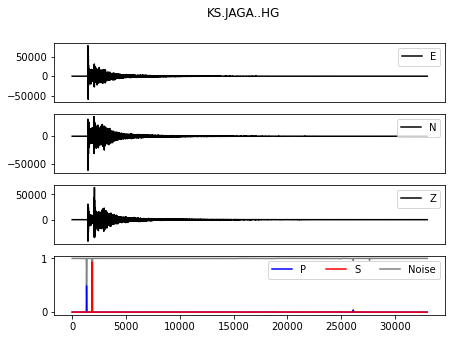

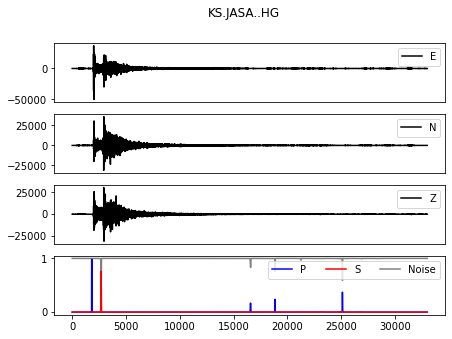

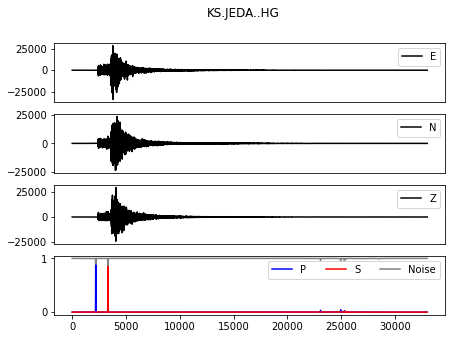

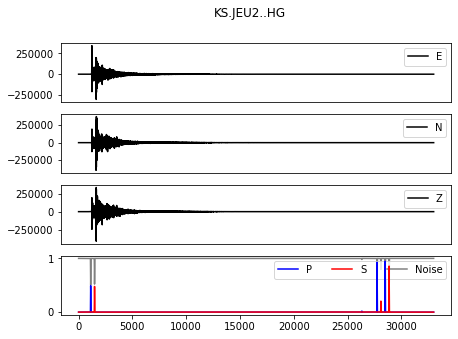

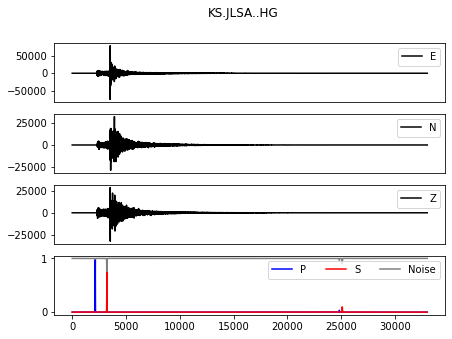

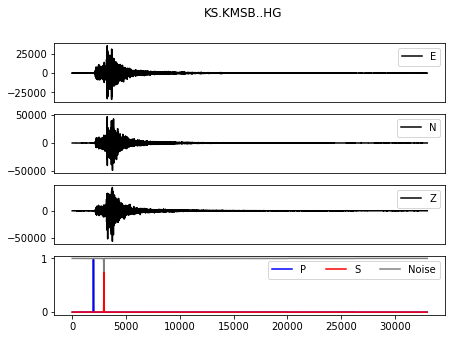

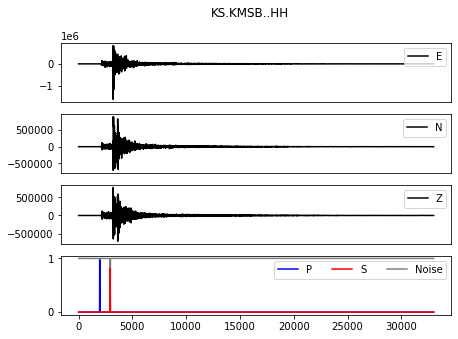

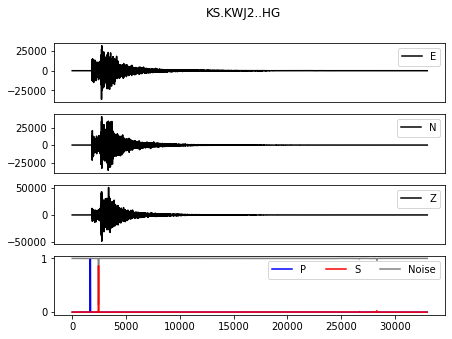

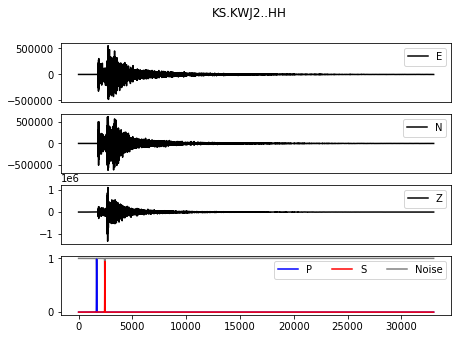

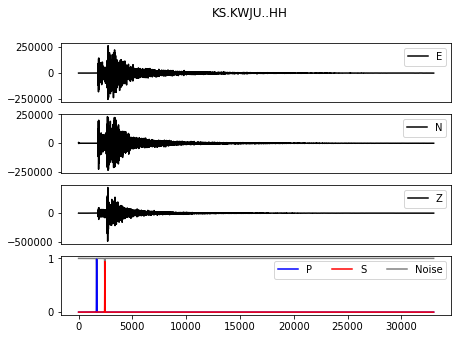

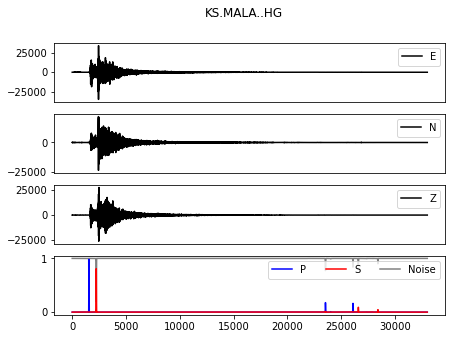

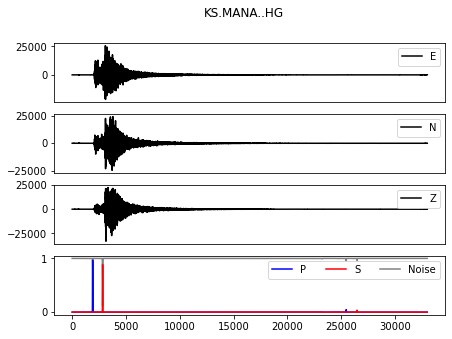

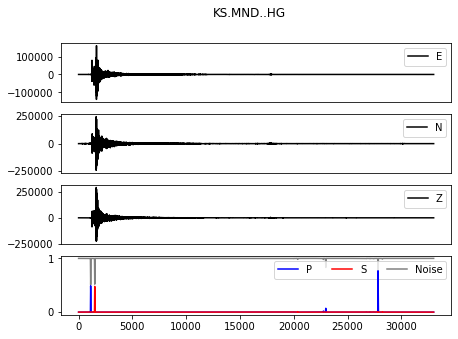

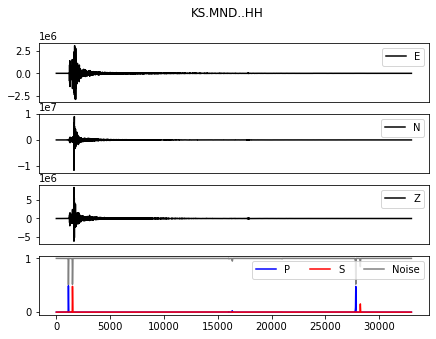

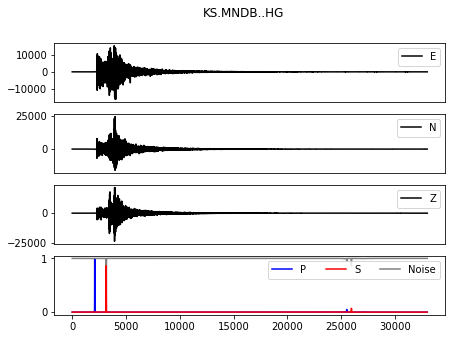

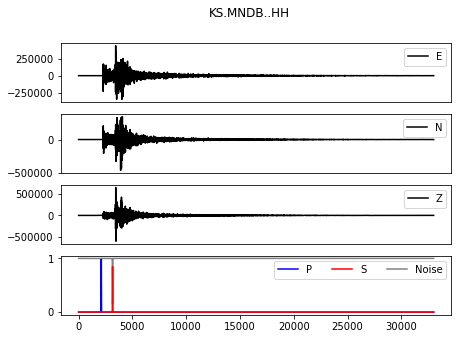

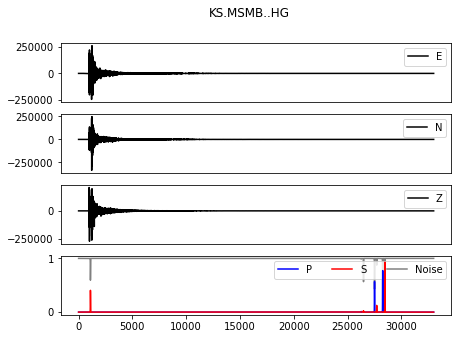

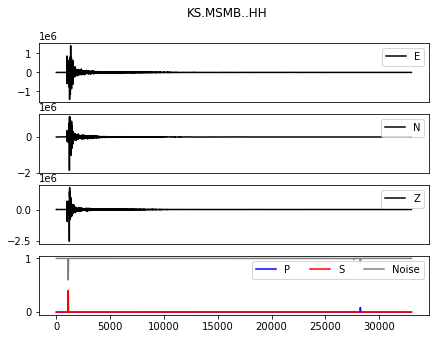

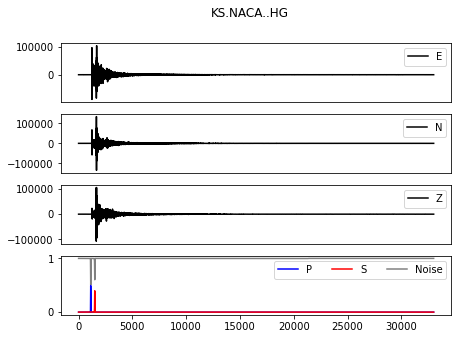

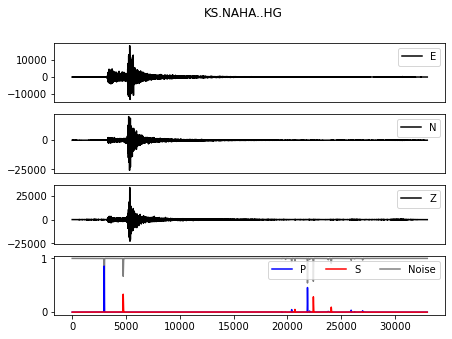

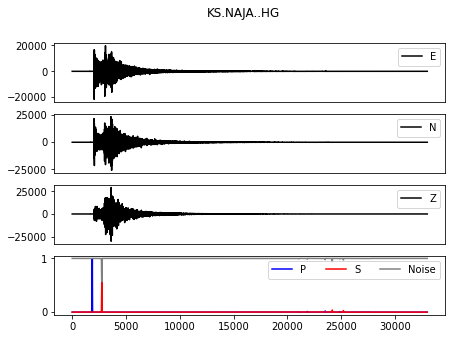

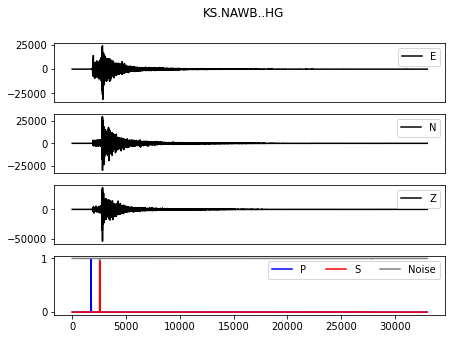

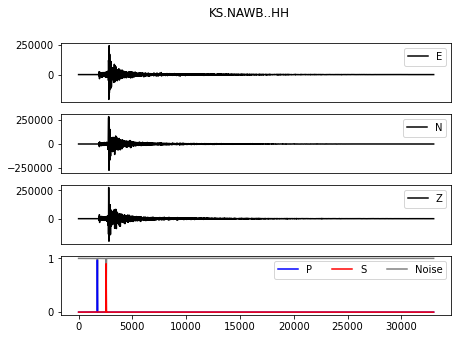

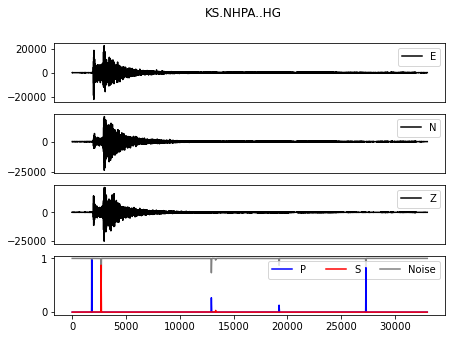

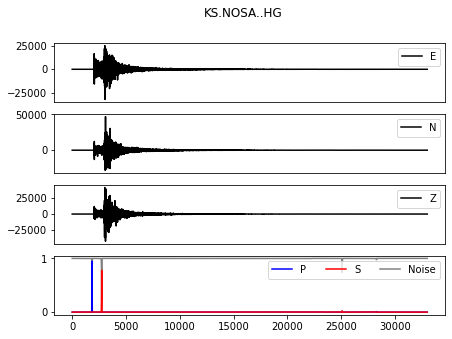

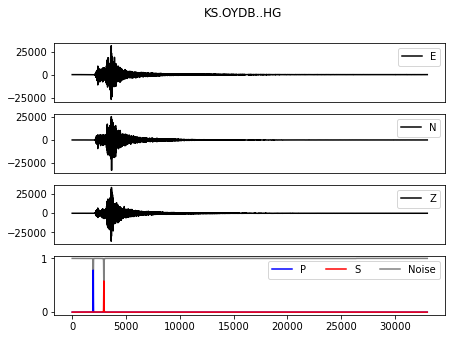

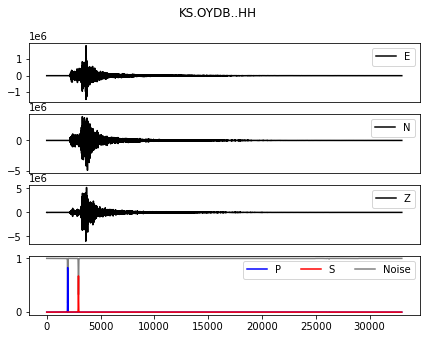

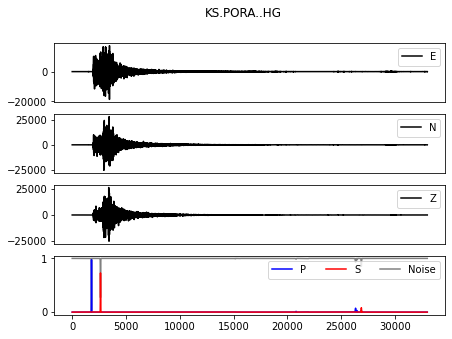

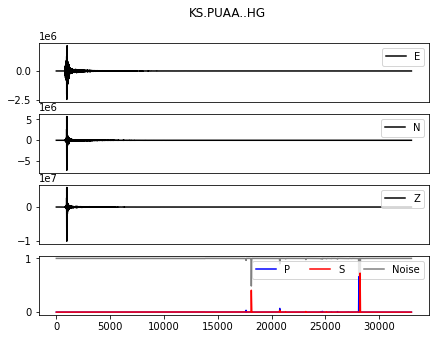

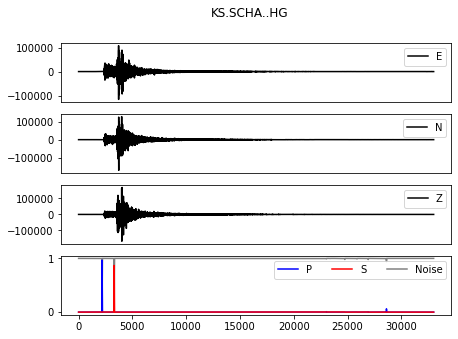

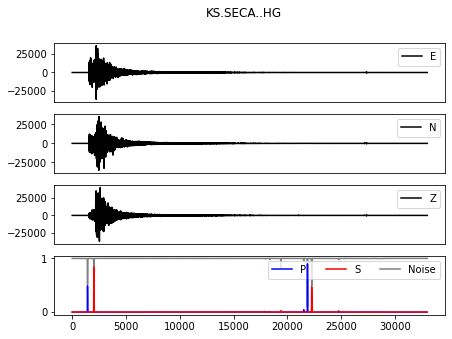

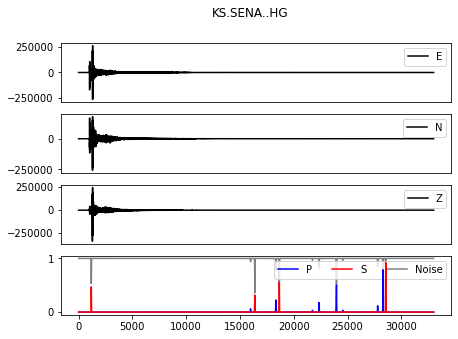

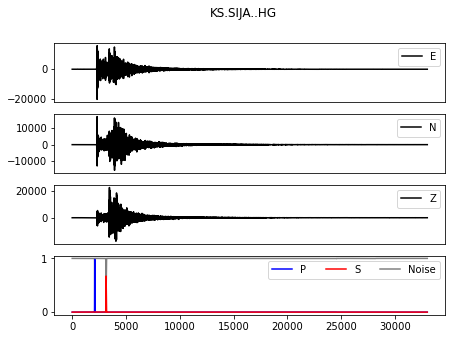

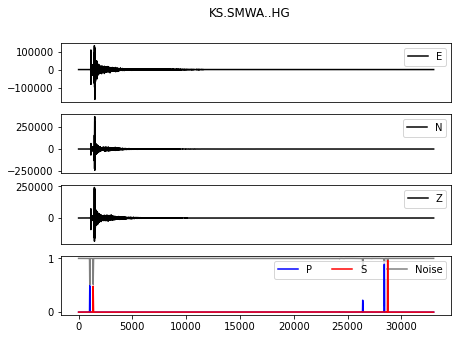

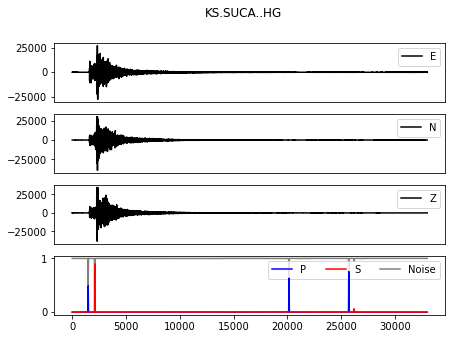

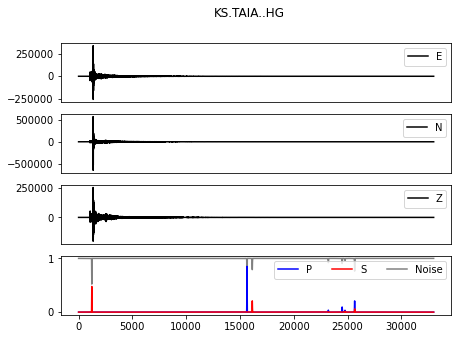

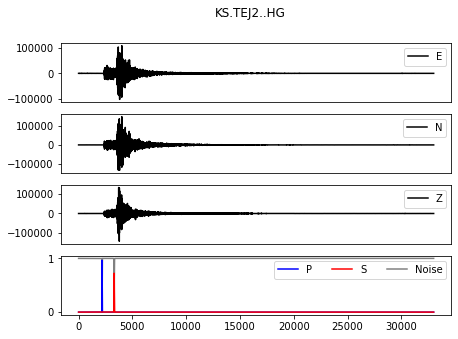

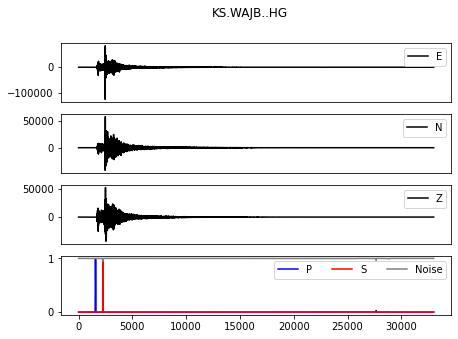

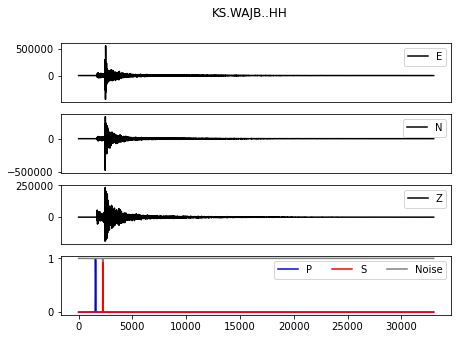

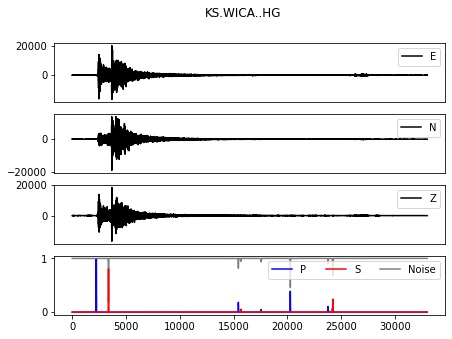

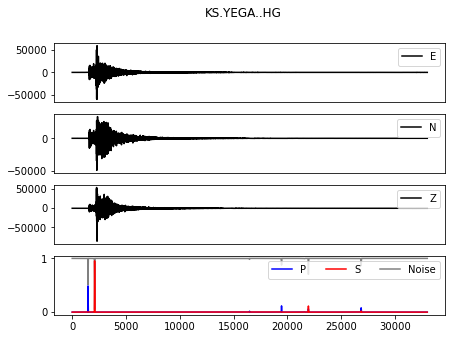

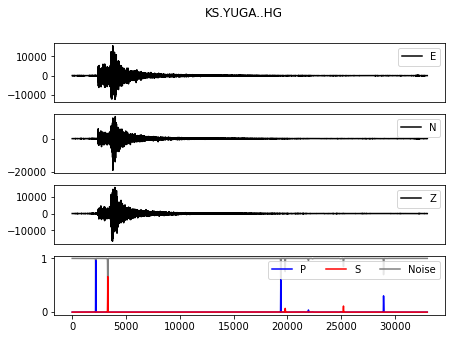

In [147]:
for idx, row in scnl_df.iterrows():
    plot_results(row.network, row.station, row.channel, data_total[idx], Y_total[idx])

In [149]:
picks_total = pd.DataFrame()
for idx, row in scnl_df.iterrows():
    arr_lst = get_picks(Y_total[idx], row.network, row.station, row.channel, row.start_time, row.sampling_rate)
    picks = pd.DataFrame(arr_lst, columns=['network','station','channel','arr','prob','phase'])
    picks_total = pd.concat([picks_total, picks])
picks_total.sort_values(by=['arr'], inplace=True)

picks_total

,network,station,channel,arr,prob,phase
0,KS,SMWA,HG,2024-06-11T23:26:54.403100Z,0.491966,P
2,KS,MSMB,HG,2024-06-11T23:26:55.019995Z,0.405298,S
0,KS,MSMB,HH,2024-06-11T23:26:55.039999Z,0.402486,S
0,KS,MND,HH,2024-06-11T23:26:55.228397Z,0.490511,P
0,KS,MND,HG,2024-06-11T23:26:55.228401Z,0.489721,P
...,...,...,...,...,...,...
6,KS,SENA,HG,2024-06-11T23:31:29.449995Z,0.923107,S
2,KS,GIJA,HG,2024-06-11T23:31:29.709991Z,0.847266,S
3,KS,SMWA,HG,2024-06-11T23:31:31.253100Z,0.961167,S
4,KS,JEU2,HG,2024-06-11T23:31:32.558401Z,0.856579,S
